In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

import bq_helper
from google.cloud import bigquery
client = bigquery.Client()

Using Kaggle's public dataset BigQuery integration.


In [3]:
bqh = bq_helper.BigQueryHelper("bigquery-public-data", "google_analytics_sample")
table_list = bqh.list_tables()
print (f'Number of tables: {len(table_list)} +  \nFirst 3 tables: {table_list[0:3]}')

Using Kaggle's public dataset BigQuery integration.
Number of tables: 366 +  
First 3 tables: ['ga_sessions_20160801', 'ga_sessions_20160802', 'ga_sessions_20160803']


In [4]:
bqh.head("ga_sessions_20170801", num_rows=3)

,visitorId,visitNumber,visitId,visitStartTime,date,totals,trafficSource,device,geoNetwork,customDimensions,hits,fullVisitorId,userId,clientId,channelGrouping,socialEngagementType
0,None,1,1501583974,1501583974,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Car...",[],"[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2248281639583218707,None,None,Organic Search,Not Socially Engaged
1,None,1,1501616585,1501616585,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Americas', 'subContinent': 'Nor...","[{'index': 4, 'value': 'North America'}]","[{'hitNumber': 1, 'time': 0, 'hour': 12, 'minu...",8647436381089107732,None,None,Organic Search,Not Socially Engaged
2,None,1,1501583344,1501583344,20170801,"{'visits': 1, 'hits': 1, 'pageviews': 1, 'time...","{'referralPath': None, 'campaign': '(not set)'...","{'browser': 'Chrome', 'browserVersion': 'not a...","{'continent': 'Asia', 'subContinent': 'Souther...","[{'index': 4, 'value': 'APAC'}]","[{'hitNumber': 1, 'time': 0, 'hour': 3, 'minut...",2055839700856389632,None,None,Organic Search,Not Socially Engaged


In [5]:
query=\
'''
select 
format("%'d",count(distinct fullVisitorId)) as users,
format("%'d",sum(totals.visits)) as visits,
format("%'d",sum(totals.pageviews)) as pageviews,
sum(totals.transactions) as transactions,
sum(totals.transactionRevenue)/1000000 as revenue
from `bigquery-public-data.google_analytics_sample.ga_sessions_*`
where _table_suffix between '20170401' and '20170801'
and totals.totalTransactionRevenue is not null
'''

job=client.query(query)
res=job.to_dataframe()
res.head()

,users,visits,pageviews,transactions,revenue
0,"3,628","4,063","98,029",4207,534873.99


#### insight : 

20170401부터 20170801까지 google store는 약 4000명의 방문자와 약 10만번의 pageview, 거래 또한 4200번정도 하며 $530000의 수익을 얻었다.

In [6]:
query = """    
    SELECT 
        DATE_TRUNC(PARSE_DATE('%Y%m%d',date), MONTH) AS month,
        SUM(totals.visits) AS visits,        
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY 1
    ORDER BY 1
"""

safe_query_job = client.query(query)
df1 = safe_query_job.to_dataframe()
df1.head()

,month,visits,revenue
0,2016-10-01,872,113329.07
1,2016-11-01,919,119013.87
2,2016-12-01,1385,153856.76


### 추론 :

12 월에는 153,000 달러 이상의 수익을 올렸고 Google 상품 매장을 거의 1400 번 방문했다. 12 월에 발생한 매출은 4 분기 매출의 40 %를 차지하며, 이는 일반적으로 소매업에서 볼 수있는 휴일 급증을 나타낸다.

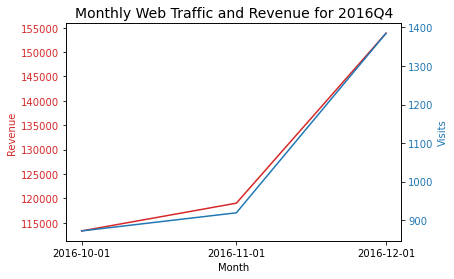

In [7]:
fig,ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Month')
ax1.set_ylabel('Revenue', color=color)
ax1.plot(df1['month'], df1['revenue'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Visits', color=color)  # we already handled the x-label with ax1
ax2.plot(df1['month'], df1['visits'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Monthly Web Traffic and Revenue for 2016Q4', fontsize=14)
plt.xticks(df1['month'],rotation=45)
plt.show()

In [8]:
# create table with revenue by country
# traffic by month
query = """
    SELECT 
        geoNetwork.country AS country,   
        SUM(totals.transactionRevenue)/1000000 AS revenue

    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY 1
    ORDER BY 2 desc
    
"""
safe_query_job = client.query(query)
df2 = safe_query_job.to_dataframe()
df2.head()


,country,revenue
0,United States,365518.96
1,Canada,9975.27
2,Kenya,3679.30
3,Puerto Rico,656.16
4,United Kingdom,527.10


In [30]:
# df2.to_csv('bigquery_df2.csv',index=False)

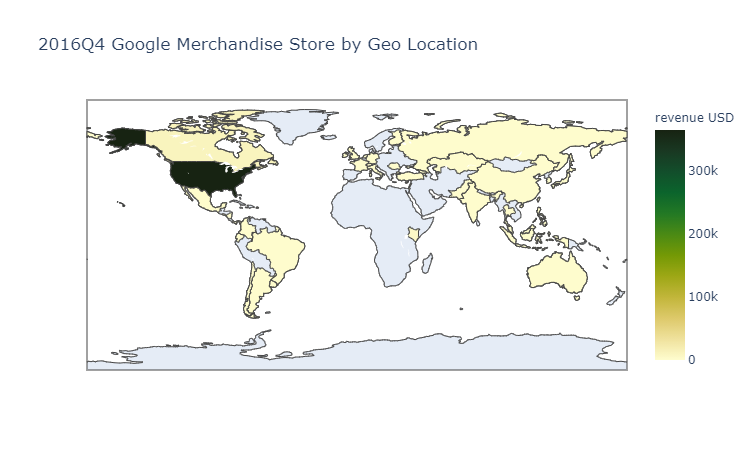

In [32]:
# create a heatmap of revenue by geo location

fig = go.Figure(data=go.Choropleth(
    locations=df2['country'], 
    z = df2['revenue'].astype(float),
    locationmode = 'country names', 
    colorscale = 'speed',
    colorbar_title = "revenue USD",
))

fig.update_layout(
    title_text = '2016Q4 Google Merchandise Store by Geo Location',)
fig.show()

## Top channels sending traffic to GM

In [10]:
# create a table of metrics by channel

query = """
    SELECT
        channelGrouping as channel,
        SUM(totals.totalTransactionRevenue)/1000000 AS revenue,
        SUM(totals.transactions) AS transactions,
        COUNT(DISTINCT fullVisitorId) AS users,
        SUM(totals.visits) AS sessions,
        SUM(totals.pageviews) AS pageviews
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND totals.totalTransactionRevenue IS NOT NULL
    GROUP BY
        1
    ORDER BY
        2 DESC
"""
safe_query_job = client.query(query)
df3 = safe_query_job.to_dataframe()
df3.head()


,channel,revenue,transactions,users,sessions,pageviews
0,Referral,182578.60,1540,1331,1470,42829
1,Direct,128141.06,568,456,539,16132
2,Organic Search,93376.88,991,905,956,28247
3,Paid Search,14028.37,164,153,160,4277
4,Display,4728.45,34,34,34,1044


Text(0.5, 1.0, 'Total Pageviews by Channel')

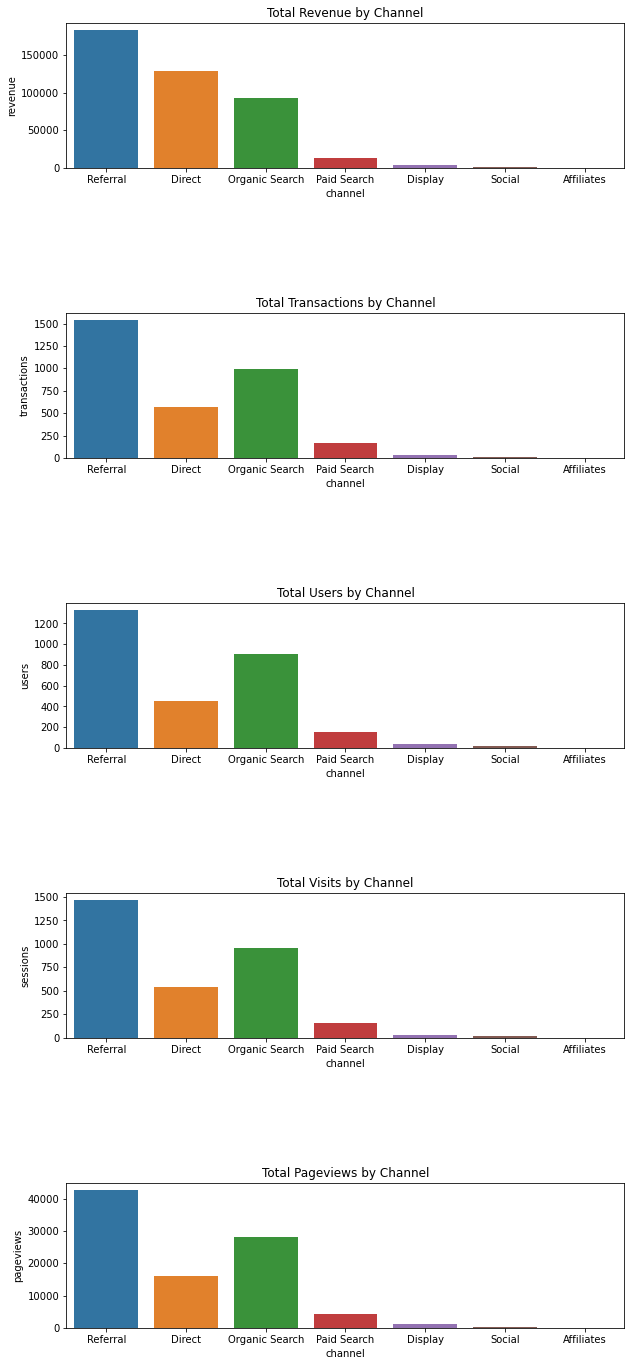

In [11]:
# set up the matplotlib figure
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, figsize=(10,24))
fig.subplots_adjust(hspace=1)

sns.barplot(x='channel',y='revenue',data=df3,estimator=sum,ax=ax1)

sns.barplot(x='channel',y='transactions',data=df3,estimator=sum,ax=ax2)

sns.barplot(x='channel',y='users',data=df3,estimator=sum,ax=ax3)

sns.barplot(x='channel',y='sessions',data=df3,estimator=sum,ax=ax4)

sns.barplot(x='channel',y='pageviews',data=df3,estimator=sum,ax=ax5)

ax1.set_title('Total Revenue by Channel')
ax2.set_title('Total Transactions by Channel')
ax3.set_title('Total Users by Channel')
ax4.set_title('Total Visits by Channel')
ax5.set_title('Total Pageviews by Channel')

### User Behavior On Google Merchandise

In [12]:
query = """
    SELECT 
        fullVisitorId AS userID,
        AVG(totals.timeOnSite) As avgTimeOnSite,
        SUM(totals.pageviews) AS pageviews,
        SUM(totals.transactions) AS transactions
    FROM 
        `bigquery-public-data.google_analytics_sample.ga_sessions_*`
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
    GROUP BY
        1
    ORDER BY 1
        
"""
safe_query_job = client.query(query)
df4 = safe_query_job.to_dataframe()

df4['transactions'].fillna(0, inplace=True)
df4.head()

,userID,avgTimeOnSite,pageviews,transactions
0,0000010278554503158,194.0,8.0,0.0
1,0000020424342248747,297.0,13.0,0.0
2,0000152474579038632,162.0,2.0,0.0
3,0000174067426171406,559.5,30.0,0.0
4,000033471059618621,NaN,1.0,0.0


In [13]:
pearson_corr = df4.corr(method='pearson')
pearson_corr

,avgTimeOnSite,pageviews,transactions
avgTimeOnSite,1.000000,0.454428,0.242365
pageviews,0.454428,1.000000,0.525083
transactions,0.242365,0.525083,1.000000


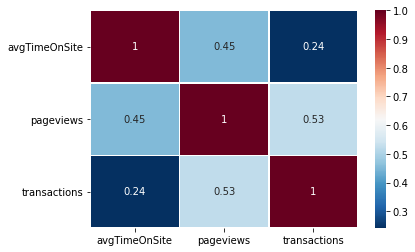

In [14]:
sns.heatmap(pearson_corr,xticklabels=pearson_corr.columns,
              yticklabels=pearson_corr.columns,cmap='RdBu_r',
              annot=True,linewidth=0.5)

### Most visited pages on site ?

In [15]:
query = """
    SELECT
        hits.page.pagePathLevel1 AS pagePath,
        SUM(totals.pageviews) AS pageviews
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
    GROUP BY 1
    ORDER BY 2 DESC
    LIMIT 10
"""
safe_query_job = client.query(query)
df5 = safe_query_job.to_dataframe()
df5


,pagePath,pageviews
0,/google+redesign/,13059899
1,/home,2320076
2,/basket.html,2251571
3,/store.html,693064
4,/signin.html,373752
5,/asearch.html,342792
6,/yourinfo.html,309919
7,/payment.html,305266
8,/ordercompleted.html,214672
9,/revieworder.html,144310


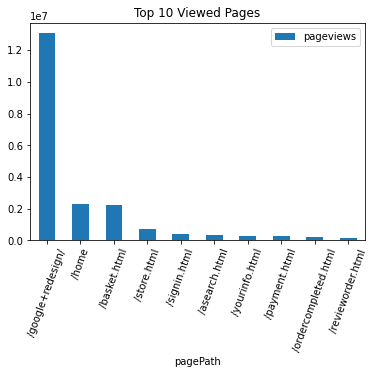

In [16]:
df5.plot.bar(x='pagePath', y='pageviews', rot=70, title='Top 10 Viewed Pages')
plt.show()

In [17]:
query = """
    SELECT
        product.v2ProductCategory AS product_category,
        product.v2ProductName AS product_name,
        product.productSKU AS product_sku,
        product.productPrice/1e6 AS product_price,
        product.productQuantity AS product_quantity,
        product.productRevenue/1e6 AS product_revenue,
        totals.totalTransactionRevenue/1e6 AS total_revenue
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits,
      UNNEST(hits.product) AS product
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
        AND productRevenue IS NOT NULL
"""
safe_query_job = client.query(query)
df6 = safe_query_job.to_dataframe()
df6.head()

,product_category,product_name,product_sku,product_price,product_quantity,product_revenue,total_revenue
0,Bottles,22 oz Android Bottle,GGOEADHH055999,2.99,1,10.99,10.99
1,Bags,Waterproof Backpack,GGOEGBRA037499,99.99,1,103.99,103.99
2,Headgear,Google Trucker Hat,GGOEGHPA002910,21.99,1,22.99,45.98
3,Headgear,YouTube Trucker Hat,GGOEYHPA003510,21.99,1,22.99,45.98
4,Drinkware,Engraved Ceramic Google Mug,GGOEGDWC020199,8.99,1,13.99,13.99


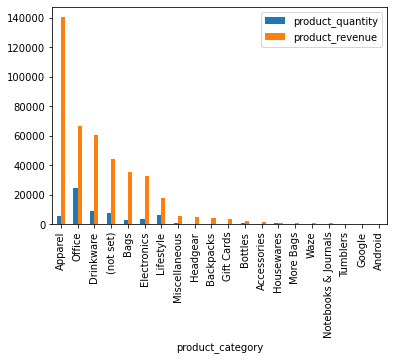

In [18]:
df6['product_category'].unique()
df6 = df6.replace(['${productitem.product.origCatName}'], 'Miscellaneous')

pivot = pd.pivot_table(df6, index=['product_category'], values=['product_revenue', 'product_quantity'], aggfunc=np.sum).sort_values(by='product_revenue', ascending=False)
pivot.plot(kind='bar')

### Shopping Cart Abandonment

In [42]:
query = """
    SELECT
        hits.eCommerceAction.action_type AS actions,
        COUNT(fullVisitorId) AS total_hits
    FROM
      `bigquery-public-data.google_analytics_sample.ga_sessions_*`,
      UNNEST(hits) AS hits,
      UNNEST(hits.product) AS product
    WHERE
        _TABLE_SUFFIX BETWEEN '20161001' AND '20161230'
    GROUP BY 
        1
    ORDER BY 1
"""
safe_query_job = client.query(query)
df7 = safe_query_job.to_dataframe()
df7.head()

,actions,total_hits
0,0,3778712
1,1,111457
2,2,92030
3,3,29151
4,4,4584


In [45]:
df7

,actions,total_hits
0,Unknown,3778712
1,Click through of product lists,111457
2,Product detail views,92030
3,Add product(s) to cart,29151
4,Remove products from cart,4584
5,Check out,60395
6,Completed purchase,19802


In [43]:
df7['actions'] = df7['actions'].astype(str)
df7['actions'] = df7['actions'].replace(['0','1','2','3','4','5','6'],
                                        ['Unknown','Click through of product lists',
                                         'Product detail views',
                                         'Add product(s) to cart',
                                         'Refund of purchase',                                         
                                         'Check out','Completed purchase'])

In [51]:
# df7.to_csv('bigquery_df7.csv',index=False)

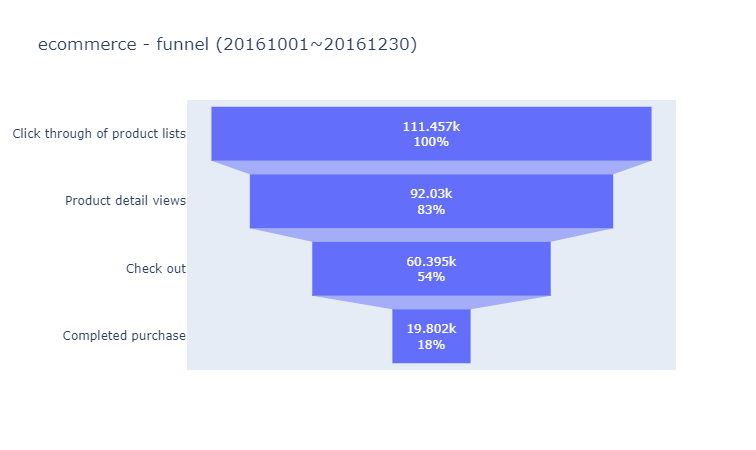

In [49]:
fig = go.Figure(go.Funnel(y = df7.iloc[[1,2,5,6]]['actions'],
                          x = df7.iloc[[1,2,5,6]]['total_hits'],
                          textposition = 'inside',textinfo = 'value+percent initial'))
fig.update_layout(title_text = 'ecommerce - funnel (20161001~20161230)')
fig.show()

### Visits per Continent

In [22]:
query = """
    SELECT geoNetwork AS place
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
"""

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
q_job = client.query(query, job_config=safe_config)

df8 = q_job.to_dataframe()

continent_lst = []
for x in df8['place']:
    x = x['continent']
    continent_lst.append(x)
df8['continents'] = continent_lst

continent_count = {'Americas': 0, 'Asia': 0, 'Europe': 0, 'Oceania': 0, 'Africa': 0}
for continent in df8['continents']:
    if continent == 'Americas':
        continent_count['Americas'] += 1
    if continent == 'Asia':
        continent_count['Asia'] += 1
    if continent == 'Europe':
        continent_count['Europe'] += 1
    if continent == 'Oceania':
        continent_count['Oceania'] += 1
    if continent == 'Africa':
        continent_count['Africa'] += 1


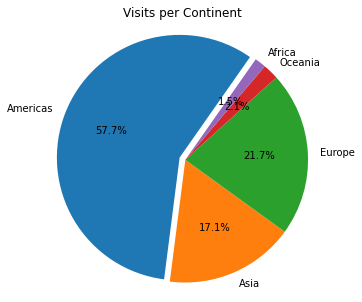

In [23]:
labels = continent_count.keys()
data = continent_count.values()
explode = (0.05, 0, 0,0,0)

plt.figure(figsize=(5,5))
plt.pie(data, labels=labels, explode=explode, autopct='%1.1f%%', startangle=55)
plt.title('Visits per Continent')
plt.axis('equal') 

plt.show()

In [24]:
query = """
     SELECT trafficSource.source AS source, COUNT(trafficSource) as counts
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801`
     GROUP BY source
     HAVING counts >= 10
     ORDER BY counts DESC
"""

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

df8 = query_job.to_dataframe()

print(df8)

                 source  counts
0              (direct)    2166
1           youtube.com     180
2  analytics.google.com      57
3              Partners      52
4                   dfa      15
5            google.com      12


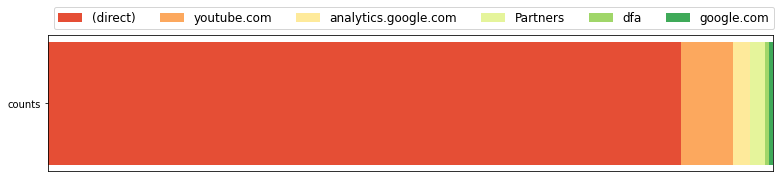

In [25]:
category_names = df8['source']
results = {'counts': df8['counts']}

def survey(results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('RdYlGn')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(13, 2.5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.5,
                label=colname, color=color)
        xcenters = starts + widths / 2

    ax.legend(ncol=len(category_names), bbox_to_anchor=(0, 1),
              loc='lower left', fontsize='large')

    return fig, ax


survey(results, category_names)
plt.show()

In [26]:
from time import time

def show_amount_of_data_scanned(query):
    dry_run_config = bigquery.QueryJobConfig(dry_run=True)
    query_job = client.query(query, job_config=dry_run_config)
    print('Data processed: {} GB'.format(round(query_job.total_bytes_processed / 10**9, 3)))
    
def show_time_to_run(query):
    time_config = bigquery.QueryJobConfig(use_query_cache=False)
    start = time()
    query_result = client.query(query, job_config=time_config).result()
    end = time()
    print('Time to run: {} seconds'.format(round(end-start, 3)))


In [27]:
query = """
     SELECT date, august.device.deviceCategory AS device, SUM(august.totals.visits) AS visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170801` AS august
     GROUP BY date, device
     UNION ALL
     SELECT date, july.device.deviceCategory as device, SUM(july.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170701` as july
     GROUP BY date, device
     UNION ALL
     SELECT date, june.device.deviceCategory as device, SUM(june.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170601` as june
     GROUP BY date, device
     UNION ALL
     SELECT date, may.device.deviceCategory as device, SUM(may.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170501` as may
     GROUP BY date, device
     UNION ALL
     SELECT date, april.device.deviceCategory as device, SUM(april.totals.visits) as visits
     FROM `bigquery-public-data.google_analytics_sample.ga_sessions_20170401` as april
     GROUP BY date, device
     ORDER BY date, device
     """

safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

df9 = query_job.to_dataframe()

print(df9)

show_amount_of_data_scanned(query)
show_time_to_run(query)


        date   device  visits
0   20170401  desktop    1420
1   20170401   mobile     646
2   20170401   tablet     104
3   20170501  desktop    1706
4   20170501   mobile     770
5   20170501   tablet     112
6   20170601  desktop    1972
7   20170601   mobile     758
8   20170601   tablet      96
9   20170701  desktop     869
10  20170701   mobile    1036
11  20170701   tablet     143
12  20170801  desktop    1742
13  20170801   mobile     725
14  20170801   tablet      89
Data processed: 0.0 GB
Time to run: 2.494 seconds


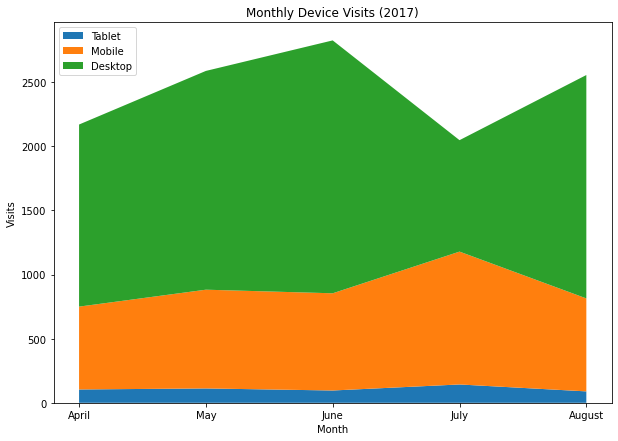

In [28]:
desktop = df9['visits'][0::3]
mobile = df9['visits'][1::3]
tablet = df9['visits'][2::3]

x = ['April', 'May', 'June', 'July', 'August']

y = np.vstack([tablet, mobile, desktop])

labels = ['Tablet', 'Mobile', 'Desktop']

plt.figure(figsize=(10,7))
plt.stackplot(x, tablet, mobile, desktop, labels=labels)
plt.title('Monthly Device Visits (2017)')
plt.ylabel('Visits')
plt.xlabel('Month')
plt.legend(loc='upper left')
plt.show()